# Describing 3D rotations of surfaces in Zemax

In [55]:
import os
import sympy as sy
import numpy as np
from functools import partial
import pyzdde.zdde as pyz

# local library
import iutils.cg.rigidbody as rb

In [12]:
sy.init_printing(use_latex='mathjax', print_builtin=False)

In [13]:
curDir = os.getcwd()
# Location of the Zemax lens files for this notebook
zmxdir = os.path.join(curDir, 'zmxfiles')
ln = pyz.createLink()
lens = "rotationMatrixStudy.ZMX"
lensPath = os.path.join(zmxdir, lens)
ln.zLoadFile(lensPath)

0

## Composition of rotation matrices

#### Background

Representation of variables in the document:

* R_xydzdd: Rotation matrix composed of sequence of **intrinsic** elemental rotations about x-axis (Rx), local y-axis (Ry), and local z-axis (Rz) in that order. Mathematically, $R_{x-y'-z''} = R_x(\theta_x) R_y(\theta_y) R_z(\theta_z)$.

* R_xyz: Rotation matrix composed of sequence of **extrinsic** elemental rotations about x-axis (Rx), local y-axis (Ry), and local z-axis (Rz) in that order. Mathematically, $R_{x-y-z} = R_z(\theta_z) R_y(\theta_y) R_x(\theta_x)$.

Notes:

1. The above rotation matrices $R_{x-y'-z''}$ and $R_{x-y-z}$ are meant to be post multiplied with the column vectors.
2. In Zemax, the sequence of rotations are *intrinsic* if the order flag is 0, and it is *extrinsic* if the order flag is 1.


#### Sequence of rotations about the x- and y- global coordinate axes

Functions for Symbolic computation:

In [14]:
thix = sy.symbols('theta_x', positive=True, real=True)
thiy = sy.symbols('theta_y', positive=True, real=True)

Rx = sy.Matrix(((1,      0     ,      0      ), 
                (0,  sy.cos(thix),  -sy.sin(thix)),
                (0,  sy.sin(thix),   sy.cos(thix)),
               ))

Ry = sy.Matrix(((sy.cos(thiy),  0, sy.sin(thiy)), 
                (0,           1,     0     ),
                (-sy.sin(thiy), 0, sy.cos(thiy)),
               ))


Rx, Ry

⎛⎡1     0        0    ⎤, ⎡cos(θ_y)   0  sin(θ_y)⎤⎞
⎜⎢                    ⎥  ⎢                      ⎥⎟
⎜⎢0  cos(θₓ)  -sin(θₓ)⎥  ⎢    0      1     0    ⎥⎟
⎜⎢                    ⎥  ⎢                      ⎥⎟
⎝⎣0  sin(θₓ)  cos(θₓ) ⎦  ⎣-sin(θ_y)  0  cos(θ_y)⎦⎠

In [21]:
# R_xy = rotation about x-axis followed by rotation about y-axis (extrinsic)
# R_yxd = rotation about y-axis followed by rotation about x-axis (intrinsic)
R_xy = R_yxd = Ry*Rx
R_xy

⎡cos(θ_y)   sin(θₓ)⋅sin(θ_y)  sin(θ_y)⋅cos(θₓ)⎤
⎢                                             ⎥
⎢    0          cos(θₓ)           -sin(θₓ)    ⎥
⎢                                             ⎥
⎣-sin(θ_y)  sin(θₓ)⋅cos(θ_y)  cos(θₓ)⋅cos(θ_y)⎦

In [16]:
# R_yx = rotation about y-axis followed by rotation about x-axis (extrinsic)
# R_xyd = rotation about x-axis followed by rotation about local y-axis (intrinsic)
R_yx = R_xyd = Rx*Ry
R_yx

⎡    cos(θ_y)          0         sin(θ_y)     ⎤
⎢                                             ⎥
⎢sin(θₓ)⋅sin(θ_y)   cos(θₓ)  -sin(θₓ)⋅cos(θ_y)⎥
⎢                                             ⎥
⎣-sin(θ_y)⋅cos(θₓ)  sin(θₓ)  cos(θₓ)⋅cos(θ_y) ⎦

Functions for Numerica computation

In [76]:
# Functions for Numeric computation
r_x = partial(rb.rotMat3D, (1,0,0), atype='d', tol=1e-12)
r_x.__doc__ = 'Elementary 3D rotation matrix about x-axis'

r_y = partial(rb.rotMat3D, (0,1,0), atype='d', tol=1e-12)
r_y.__doc__ = 'Elementary 3D rotation matrix about y-axis'

r_xy = lambda thetaX, thetaY : r_y(thetaY) * r_x(thetaX)
r_xy.__doc__ = "Rotation marix as extrinsic composition: x-y"

r_xyd = lambda thetaX, thetaY : r_x(thetaX) * r_y(thetaY)
r_xyd.__doc__ = "Rotation matrix as intrinsic composition: x-y'"



r_yx = lambda thetaX, thetaY : r_x(thetaX) * r_y(thetaY)
r_yx.__doc__ = "Rotation marix as extrinsic composition: y-x"

r_yxd = lambda thetaX, thetaY : r_y(thetaY) * r_x(thetaX)
r_yxd.__doc__ = "Rotation matrix as intrinsic composition: y-x'"



Function for Zemax computation

Elementary rotations in Zemax are essentially intrinsic. But since you can change the order of rotations, you can make it behave like extrinsic:
If the order flag is 0, the actual rotation is $x-y'-z''$.
If the order flag is 1, the actual rotation is $z-y'-x''$ which is mathematically equivalent to $x-y-z$

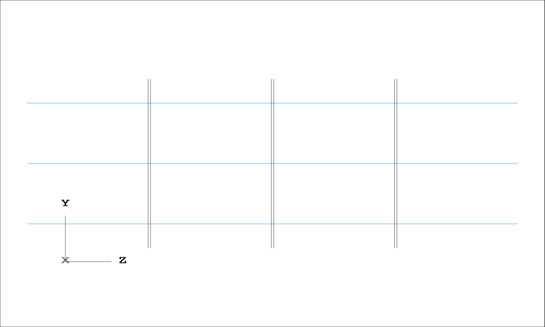

In [18]:
ln.ipzCaptureWindow('L3d')

In [48]:
def rotate_surfaces(ln, thetaX, thetaY, cbRot, cbRotBack, rtype='intrinsic'):
    """set the rotations using coordinate breaks, return rotation matrix
    
    """
    order = 0 if rtype=='intrinsic' else 1
    ln.zSetSurfaceParameter(surfNum=cbRot, param=6, value=order)
    ln.zSetSurfaceParameter(surfNum=cbRot, param=3, value=thetaX)  
    ln.zSetSurfaceParameter(surfNum=cbRot, param=4, value=thetaY)
    ln.zSetSurfaceParameter(surfNum=cbRotBack, param=6, value=int(not(order)))
    ln.zGetUpdate()
    rot_mat = np.array(ln.zGetGlobalMatrix(cbRot)[:9]).reshape(3,3)
    return rot_mat

### Verification

##### (1) Rotation about x-axis by 25°:

In [70]:
# Rotation matrix @ Zemax
thetaX, thetaY = 25, 0
rotate_surfaces(ln, thetaX=thetaX, thetaY=thetaY, cbRot=4, cbRotBack=7, rtype='intrinsic')

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779, -0.42261826],
       [ 0.        ,  0.42261826,  0.90630779]])

In [71]:
# Rotation matrix using Symbolic computation
R_xyd.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡1          0                  0         ⎤
⎢                                        ⎥
⎢0  0.90630778703665   -0.422618261740699⎥
⎢                                        ⎥
⎣0  0.422618261740699   0.90630778703665 ⎦

In [77]:
# Roation matrix using Numerical computation
r_xyd(thetaX, thetaY)

matrix([[ 1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.90630779, -0.42261826],
        [ 0.        ,  0.42261826,  0.90630779]])

##### (2) Rotation about y-axis by -35°:

In [78]:
# Rotation matrix @ Zemax
thetaX, thetaY = 0, -35
rotate_surfaces(ln, thetaX=thetaX, thetaY=thetaY, cbRot=4, cbRotBack=7, rtype='intrinsic')

array([[ 0.81915204,  0.        , -0.57357644],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.57357644,  0.        ,  0.81915204]])

In [79]:
# Rotation matrix using Symbolic computation
R_xyd.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡0.819152044288992  0  -0.573576436351046⎤
⎢                                        ⎥
⎢        0          1          0         ⎥
⎢                                        ⎥
⎣0.573576436351046  0  0.819152044288992 ⎦

In [80]:
# Roation matrix using Numerical computation
r_xyd(thetaX, thetaY)

matrix([[ 0.81915204,  0.        , -0.57357644],
        [ 0.        ,  1.        ,  0.        ],
        [ 0.57357644,  0.        ,  0.81915204]])

##### (3) Intrinsic Rotation about x-axis by 10° followed by rotation about y-axis by 15°

In [89]:
# Rotation matrix @ Zemax
thetaX, thetaY = 10, 15
rotate_surfaces(ln, thetaX=thetaX, thetaY=thetaY, cbRot=4, cbRotBack=7, rtype='intrinsic')

array([[ 0.96592583,  0.        ,  0.25881905],
       [ 0.04494346,  0.98480775, -0.16773126],
       [-0.254887  ,  0.17364818,  0.95125124]])

In [90]:
# Rotation matrix using Symbolic computation
R_xyd.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡0.965925826289068           0          0.258819045102521 ⎤
⎢                                                         ⎥
⎢0.0449434555275478  0.984807753012208  -0.167731259496521⎥
⎢                                                         ⎥
⎣-0.254887002244179  0.17364817766693   0.951251242564198 ⎦

In [91]:
# Rotation matrix using Symbolic computation (Mathematically equivalent to extrinsic rotation R_yx)
R_yx.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡0.965925826289068           0          0.258819045102521 ⎤
⎢                                                         ⎥
⎢0.0449434555275478  0.984807753012208  -0.167731259496521⎥
⎢                                                         ⎥
⎣-0.254887002244179  0.17364817766693   0.951251242564198 ⎦

In [92]:
# Rotation matrix using Numerical computation
r_xyd(thetaX, thetaY)

matrix([[ 0.96592583,  0.        ,  0.25881905],
        [ 0.04494346,  0.98480775, -0.16773126],
        [-0.254887  ,  0.17364818,  0.95125124]])

In [ ]:
# Rotation matrix using Numerical computation (Mathematically equivalent to extrinsic rotation R)
r_xyd(thetaX, thetaY)

##### (4) Extrinsic Rotation about x-axis by 12° followed by rotation about y-axis by -8°

In [84]:
# Rotation matrix @ Zemax
thetaX, thetaY = 12, -8
rotate_surfaces(ln, thetaX=thetaX, thetaY=thetaY, cbRot=4, cbRotBack=7, rtype='extrinsic')

array([[ 0.99026807, -0.02893571, -0.13613183],
       [ 0.        ,  0.9781476 , -0.20791169],
       [ 0.1391731 ,  0.20588831,  0.96862834]])

In [85]:
# Rotation matrix using Symbolic computation
R_yx.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡0.99026806874157   -0.0289357147369579  -0.136131834790772⎤
⎢                                                          ⎥
⎢        0           0.978147600733806   -0.207911690817759⎥
⎢                                                          ⎥
⎣0.139173100960065   0.205888308534897   0.968628335522866 ⎦

In [87]:
# Rotation matrix using Symbolic computation (Mathematically eqivalent to intrinsic rotation R_yxd)
R_yxd.subs({thix:np.deg2rad(thetaX), thiy:np.deg2rad(thetaY)})

⎡0.99026806874157   -0.0289357147369579  -0.136131834790772⎤
⎢                                                          ⎥
⎢        0           0.978147600733806   -0.207911690817759⎥
⎢                                                          ⎥
⎣0.139173100960065   0.205888308534897   0.968628335522866 ⎦

In [86]:
# Roation matrix using Numerical computation
r_xy(thetaX, thetaY)

matrix([[ 0.99026807, -0.02893571, -0.13613183],
        [ 0.        ,  0.9781476 , -0.20791169],
        [ 0.1391731 ,  0.20588831,  0.96862834]])

In [88]:
# Roation matrix using Numerical computation (Mathematically equivalent to intrinsic rotation r_yxd)
r_yxd(thetaX, thetaY)

matrix([[ 0.99026807, -0.02893571, -0.13613183],
        [ 0.        ,  0.9781476 , -0.20791169],
        [ 0.1391731 ,  0.20588831,  0.96862834]])